# Digital Signal Processing (DSP)

## Seminar 

Acknowledgement: this notebook is inspired by speech course from Andrei Malinin

The contest is available by the link: `<TBD>`

In [ ]:
# %pip install librosa numpy matplotlib scipy

In [1]:
from pathlib import Path

from IPython.display import display, Audio

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from plotting_utils import *
from transforms import *
from tests import *
from utils import *

In [3]:
sample_rate = 22050
data_path = Path("../data")
seminar_name = "01_DSP"
samples_path = data_path / seminar_name / "examples"

To download the required files, uncomment the following line.

In [4]:
# !mkdir -p ../data
# link_to_archive = "https://disk.yandex.ru/d/uV1jDE4Ku5KMuw"
# download_file(link_to_archive, "../data/01_DSP.zip")
# !unzip ../data/01_DSP.zip -d ../data
# !rm ../data/01_DSP.zip

In [5]:
def create_examples_dict(directory="../data/01_DSP/examples", sample_rate=sample_rate):
    directory = Path(directory)

    examples = {}
    for wav_path in directory.iterdir():
        if wav_path.suffix == ".wav":
            wav, sr = librosa.load(str(wav_path))
            assert sr == sample_rate, f"Working only with audio of sample_rate {sample_rate}"
            examples[wav_path.stem] = wav
    return examples

examples = create_examples_dict(directory=samples_path)
wav = examples["babenko"]

In [6]:
display(Audio(wav, rate=sample_rate))

We will apply our transformation to this wav. Then see how it changes.

### 1. WAV (Waveform Audio Format)

Sound is recorded by a microphone. It registers a serie of amplitudes of air-pressure. The frequency, at which microphone records amplitudes is called sample-rate. Typicaly, this frequency can be 16kHz, 22kHz or 48kHz, depending on what quality of audio one aim to record.


In [7]:
wav_44kHz, orig_sr = librosa.load(str(data_path / seminar_name / "sample_44kHz.wav"), sr=44100)
print(f"Original sample rate: {orig_sr}")
for target_sr in [44100, 24000, 22050, 16000, 8000, 4000]:
    resampled_wav = librosa.resample(wav_44kHz, orig_sr=orig_sr, target_sr=target_sr)
    print(f"Resampled SR: {target_sr}")
    display(Audio(resampled_wav, rate=target_sr))

Original sample rate: 44100
Resampled SR: 44100


Resampled SR: 24000


Resampled SR: 22050


Resampled SR: 16000


Resampled SR: 8000


Resampled SR: 4000


In this seminar we will use samples recorded at 22kHz, which means that each second of recorded sound will contain 22 thousand (22050 actually) amplitude samples per second. Consider the short audio files below:

In [8]:
print(f"{wav.shape=} {sample_rate=}")
display(Audio(wav, rate=sample_rate))

wav.shape=(88200,) sample_rate=22050


/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


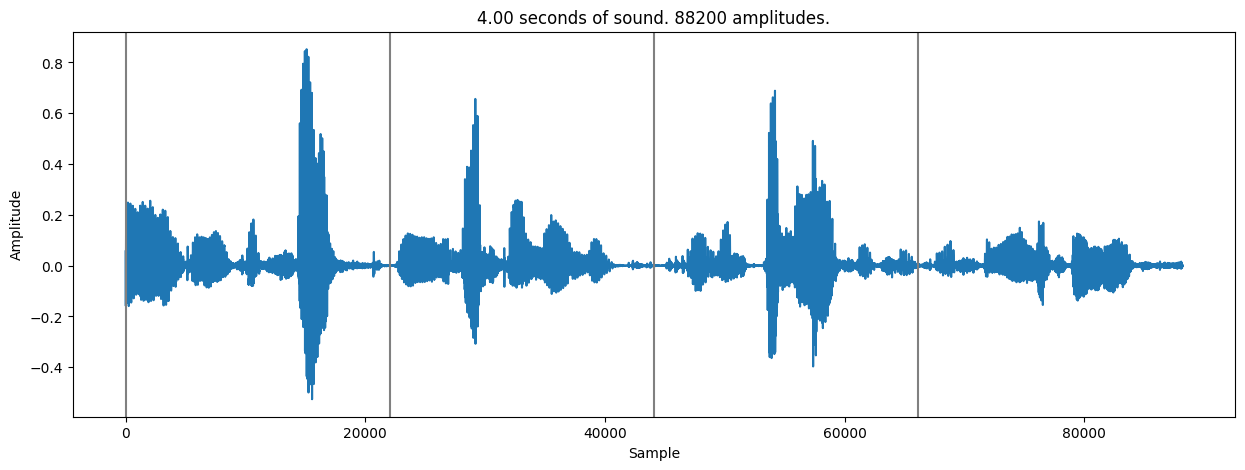

In [9]:
plot_wav(wav, sample_rate, end=None)

As you can see, waveform is a redundant representation. __4-second__ audio sample where only __7 words__ are said, contains __87040__ amplitude samples! This is extremely difficult to process directly, because there's so many of them! It is far more than a typical sequence length for NLP applications. Thus, we need to compress this information to a more manageable size!

A typical solution is to use __spectrogram__: instead of saving thousands of amplitudes, we can perform [Fourier transformation](https://en.wikipedia.org/wiki/Fourier_transform) to find which periodics are prevalent at each point in time. More formally, a spectrogram applies [Short-Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to small overlapping windows of the amplitude time-series. Let us describe this pipeline and step by step

### 1.1 Let's listen to different sample rates

### 2. Windowing
Our speech is non-stationary and varies over time. Thus, we do not want to apply DFT to the whole recording, as it does not help us to retrieve information from the recording. What we actually want - is to see how local spectral characteristics change over time. That's why we slice our recording into overlapping windows and apply DFT to this window. This slicing has two important characteristics:
- **Window_size** - the size of the window. Typically, it is 1024 or 2048 samples, which is roughly 0.05 - 0.1 seconds of audio. (Really so small)
- **Hop_length** - the size of the step, between starts of two contiguous windows. Usually is equals to window_size // 4.

As the hop_length is smaller than window size, the windows overlap on each other. And each sample from the wav is duplicated (window_size // hop_length) times.

Now you need to implement Windowing class.
- Middle of $i-th$ window (element of window with index `win_size // 2`) should lean on `(i * hop_length)`-th element of the original wav
- To do that zero-pad left and right borders of the wav
- The expectend number of windows is `(wav_size - window_size % 2) // hop_length + 1`

**Assignment**: Implement `transforms.Windowing`

In [10]:
assert test_windowing(testing_class=Windowing, n_repeats=1000)

window_size=2048 hop_length=512 n_hops_in_win=4


/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


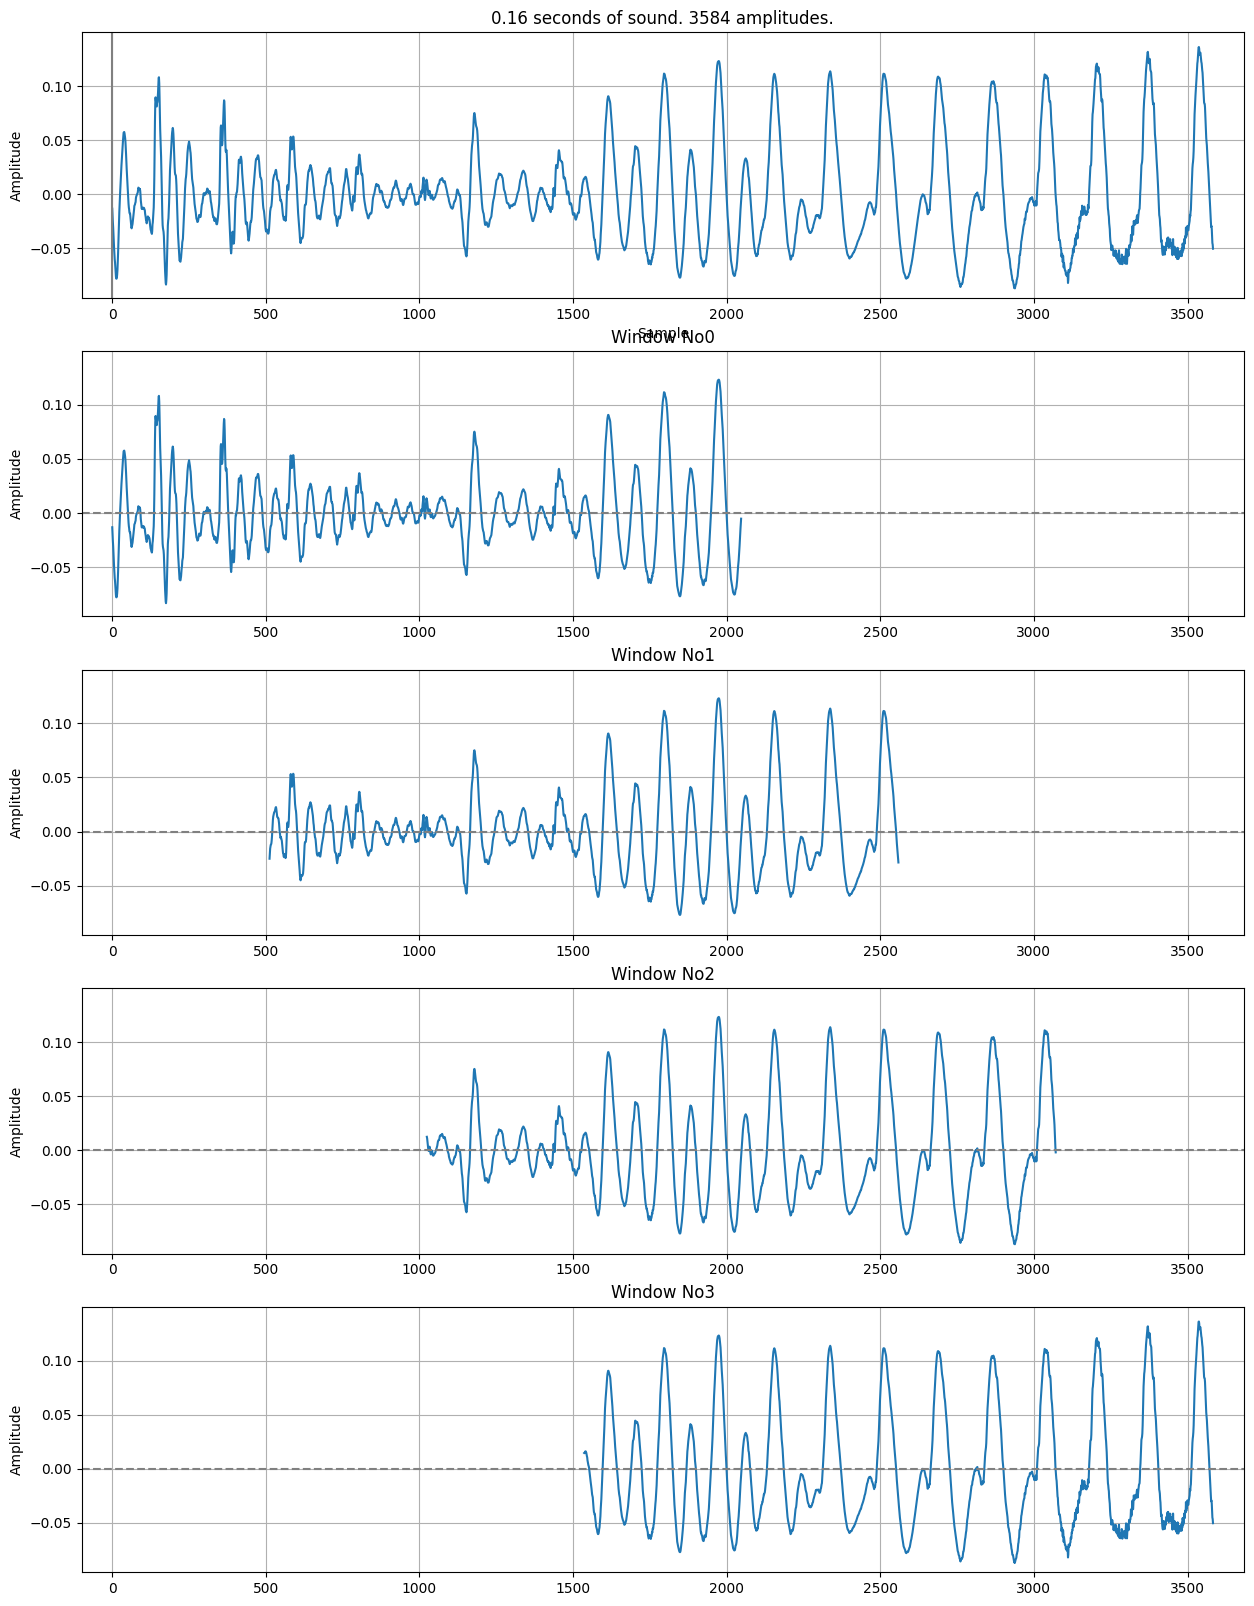

In [11]:
start, length = 4000, 3584
plot_windowing(wav[start:start + length], windowing_class=Windowing, n_subpictures=4)

This picture shows, how $0.16$ seconds of audio transform into several short frames, $0.09$ seconds each. The important thing here is that they intersect, quite significantly.

Let's apply apply the transformation to the whole wav, and see what we've got.

/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


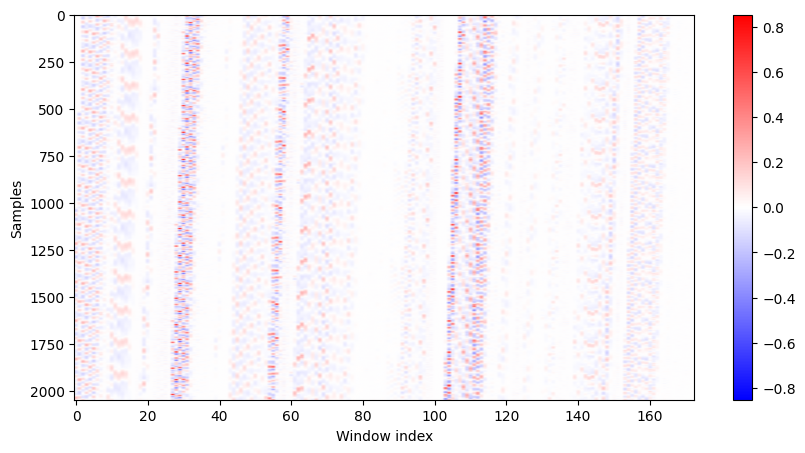

In [12]:
windowing_transform = Windowing(window_size=2048, hop_length=512)
windows = windowing_transform(wav)
plot_windowed_wav(windows)


Doesn't look like something meaningful, so let's continue doing some other transforms

### 3. Hann window
If we apply DFT to each window, resulted from the previous step, we'll get so called spectral leakage. Let me try to give you an intuition, of what it is:

Fourier transform assumes, that the function is periodic and continuous.
We can make function periodic, by pretending, that we loop it.
But when we loop it, we break its continuousness, as the function does not match at the ends.
To address this, we need our function to be equal from both sides, for example make it equal to zero.
To smoothly bring the function to zero at the ends, we multiply it by hahn function elementwise.
This function equals 1 in the middle, and zero at the ends (like on following picture)

This guy explains that better:
https://www.youtube.com/shorts/xoE2rnwFROs

/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


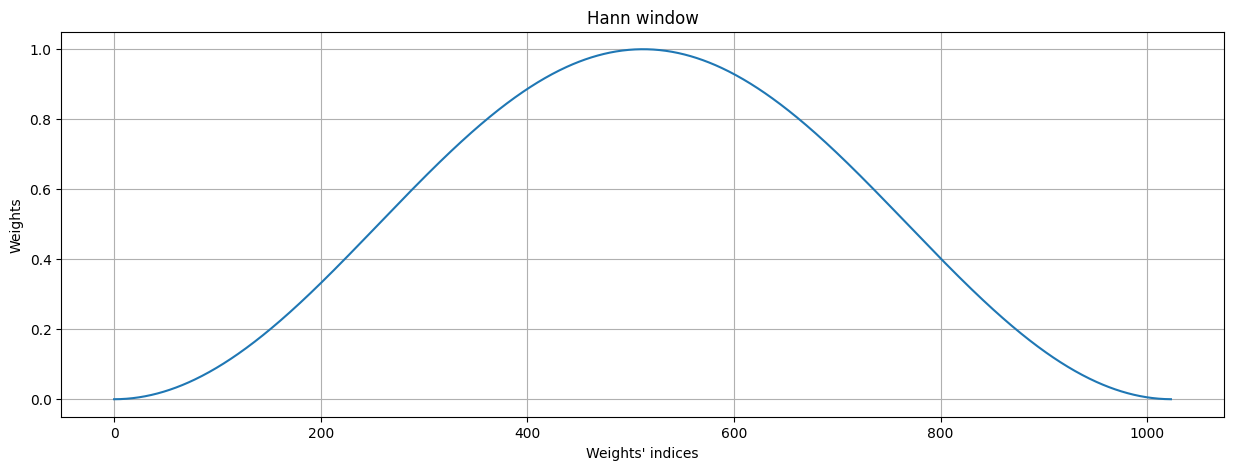

In [13]:
plot_hann_window()

To get Hann Window weights, you can use [scipy function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hann.html).
Don't forget ot set `sym=False`.

**Assignment**: Implement `transforms.Hann`

In [14]:
assert test_hann(testing_class=Hann)

Let's see what we've got

/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:184: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


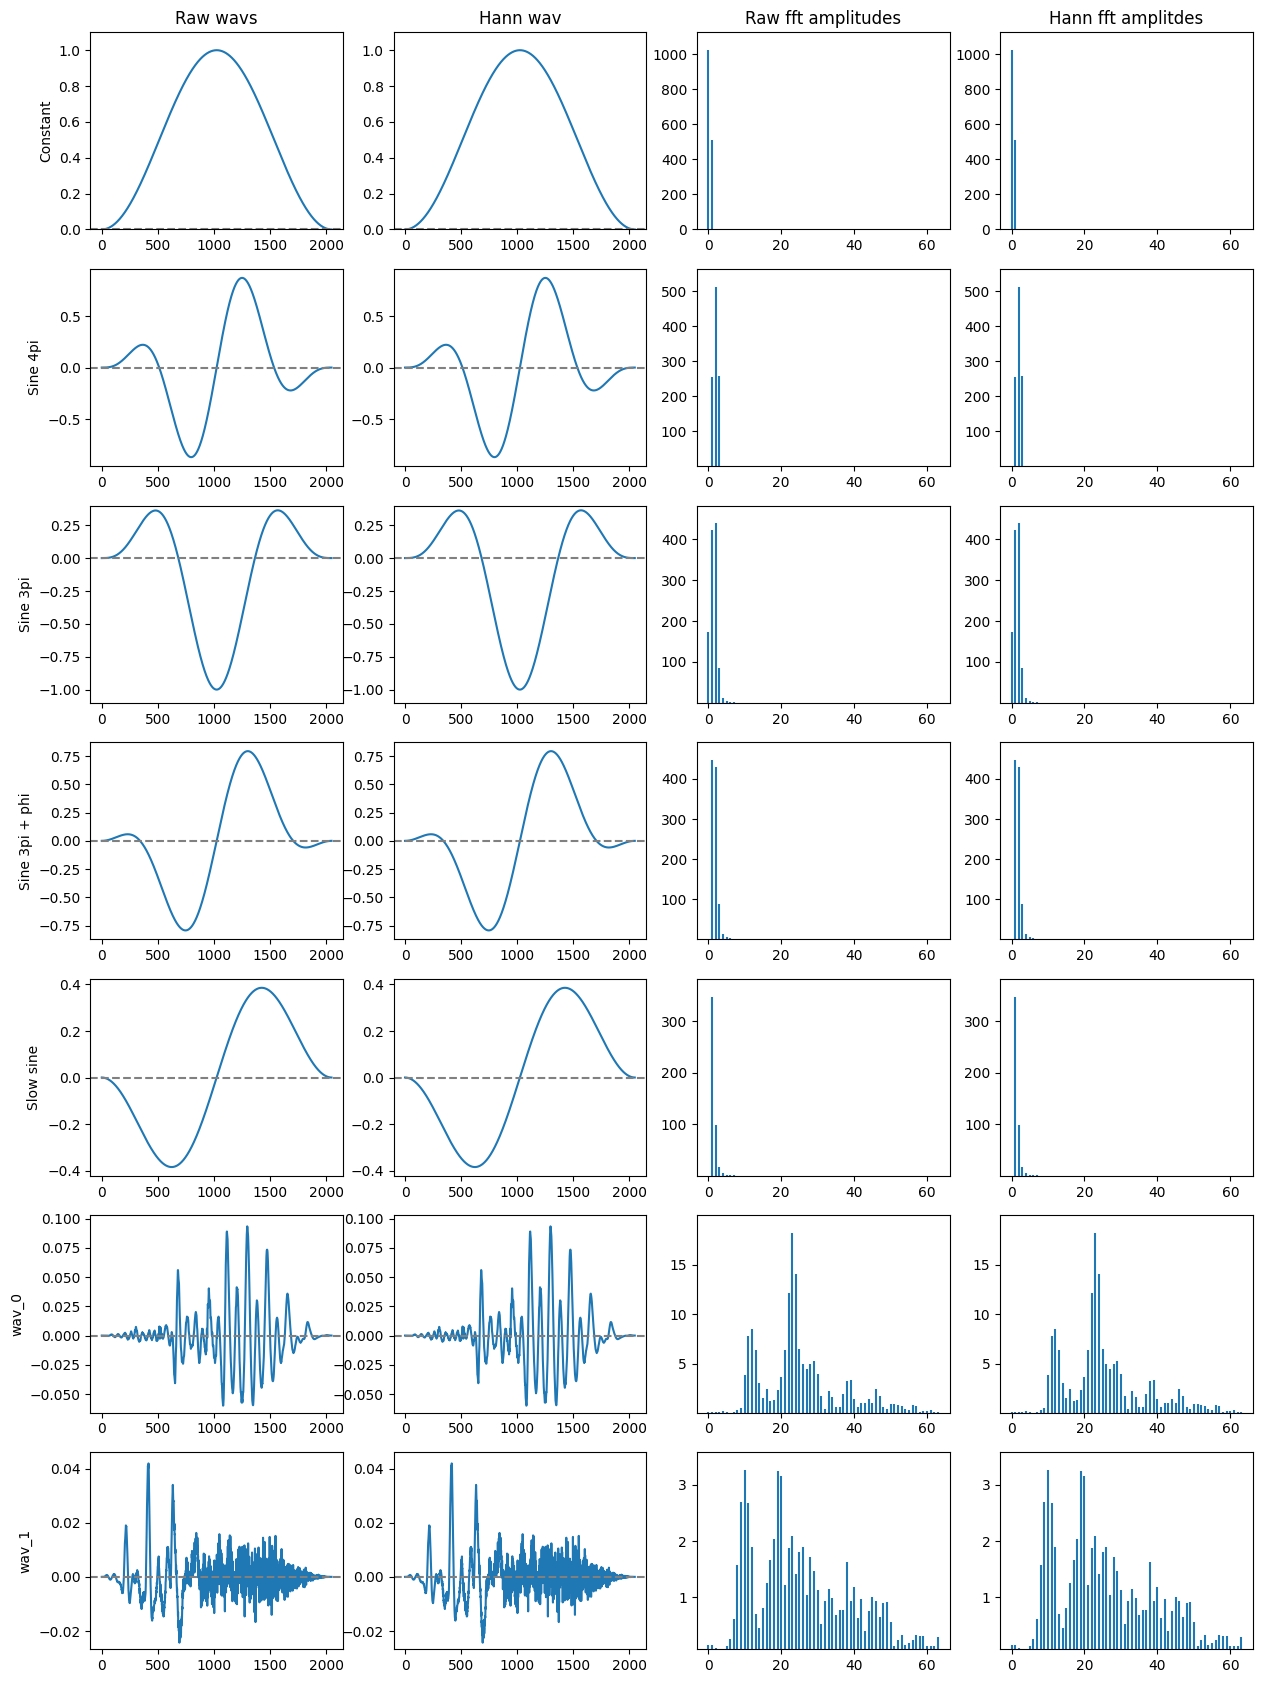

In [15]:
start1, start2, length = 4500, 10450, 2048 
demo_tensor = get_demo_tensor([wav[start1:start1 + length], wav[start2:start2 + length]])
plot_hann(demo_tensor)

Let's apply our new transform to the windows we've got from the previous step.

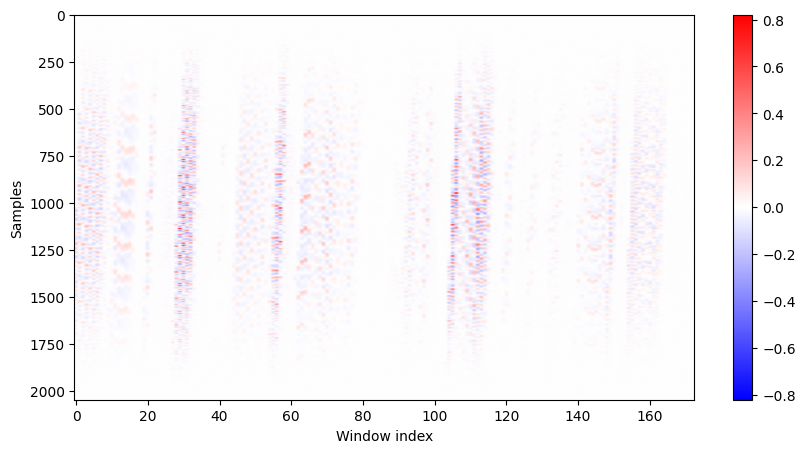

In [16]:
hann_transform = Hann(window_size=2048)
hann_windows = hann_transform(windows)
plot_windowed_wav(hann_windows)

### 4. FFT

The Short-Time Fourier Transform (STFT) is based on the Fast Fourier Transform (FFT), which is a fast implementation of the Discrete Fourier Transform (DFT). DFT is actually what we want to do :)

In numpy, there are two types of FFTs: [np.fft.fft](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft) and [np.fft.rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html#numpy.fft.rfft). Let's explore the differences between them.

It's important to note that the results of these functions are complex-valued arrays.

Below is a plot depicting the magnitudes and phases of both FFT and RFFT results.

/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:259: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


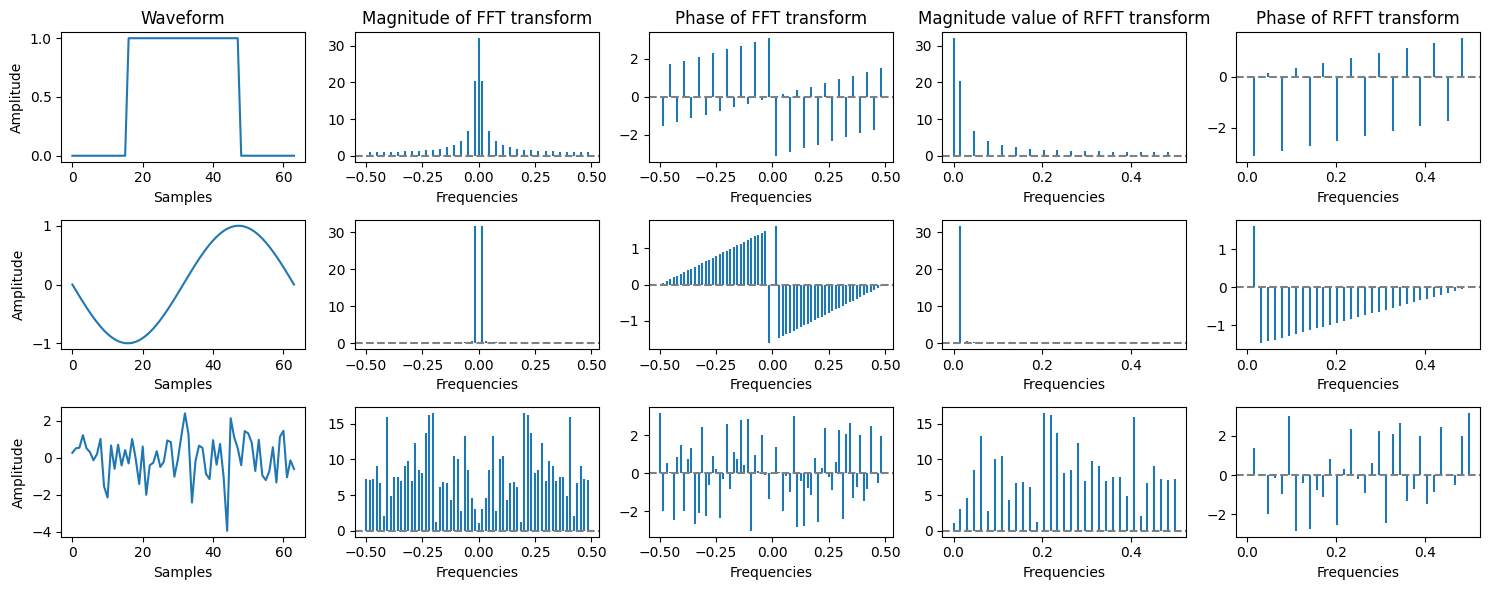

In [17]:
plot_fft_difference()

Let's understand, what happens on this plot.

We've seen a formulae of DFT on the lecture:
$$
X(n) = \sum_{k=0}^{N-1} x(k) e^{-2 \pi i \frac {n}{N}k}
$$

In this formulae $\frac{n}{N}$ is the frequency, that we have over the x-axis.
Let's deduce two important properties of this formulae.

1) For complex $x(k)$
$$
X(N + n) = \sum_{k=0}^{N-1} x(k) \exp(-2 \pi i \frac{N + n}{N} k) = \sum_{k=0}^{N-1} x(k) \exp(-2 \pi i \frac{n}{N} k - \cancel{2 \pi i n k}) = \sum_{k=0}^{N-1} x(k) \exp(-2 \pi i \frac{n}{N} k) \\
X(N + n) = X(n)
$$

2) For real $x(k)$
$$
X(N - n) = \sum_{k=0}^{N-1} x(k) \exp(-2 \pi i \frac{N - n}{N} k) = \sum_{k=0}^{N-1} x(k) \exp(2 \pi i \frac{n}{N} k - \cancel{2 \pi i n k}) = \sum_{k=0}^{N-1} x(k) \exp(2 \pi i \frac{n}{N} k) \\
X(N - n) = X^{*}(n)
$$

What are the conclusions from this formulae.
- The result of the formulae is periodical with period $N$. That's why if we want to colculate several values of this function for several frequencies, we can take frequencies $n$ from a range of size $N$.
- In the implementation of DFT in numpy ([np.fft.fft](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft])) this range is chosen to be $n \in [- \frac{N}{2}; + \frac{N}{2}]$, or in terms of numpy : $\frac{n}{N} \in [-\frac{1}{2}; +\frac{1}{2}]$.
- We work with real-value samples as input of this function. And we want the absolutes of the results. That means, that according to formulae 2, we will get a symmetric result, $|X(n)| == |X^{*}(N - n)|$.
- For this case we have another function [np.fft.rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html), which calculates the DFT for range $n \in [0, \frac{N}{2}]$.

The same exact explanation you can see in [np.fft documentation](https://numpy.org/doc/stable/reference/routines.fft.html).

Now, given this knowledge, let's implement the DFT method.
What is it expected to do:
- Get the real-value matrix and apply DFT transformation to each of this column. 
- Return the real-value result.
- It has `n_freqs` parameter. If it is `None`, we return all of the frequencies. If it is an integer, we return only the `n_freqs` lowest frequencies. 

**Assignment**: Implement `transforms.DFT`

In [18]:
assert test_dft(testing_class=DFT)

Now let's see what we've got 

/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


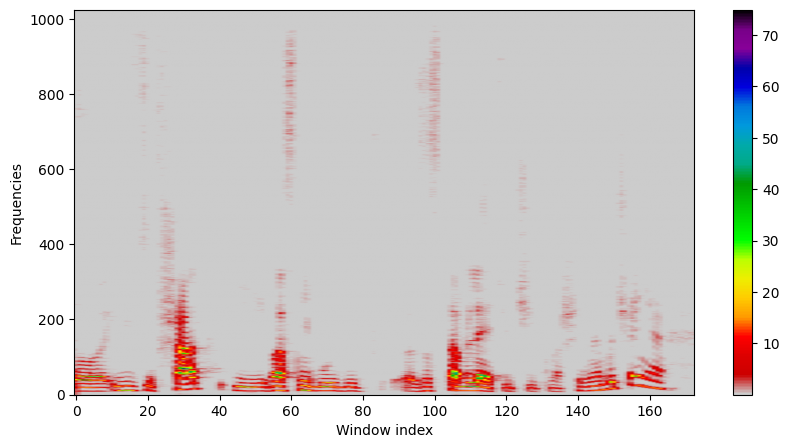

In [19]:
dft_transform = DFT()
spec = dft_transform(hann_windows)
plot_dft(spec)

### 5. MelScale

Initially one second of audio wav represented by 16k samples per second.
We have transformed our wav in more convenient form but bitrate of the wav stayed almost the same $~(sample\_rate \ // \ hop\_length) \times n\_fft \simeq 16k$ floats, representing 1 secong of audio. We won 2x space we get rid imaginary part of the signal and switched to the energy of harmonics. We lost space because overlaping of fft windows. 

But now we can use our knowledge of psychoacoustic as not all frequencies are useful.
Different frequencies of the spectrum have different contribution for audio perception.
Low frequencies are more important and high frequencies are less important as it was explained in the first lecture.
We can apply to spectrogram by multiplying amplitudes on mel-scale matrix.
You can see one below.

/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:197: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


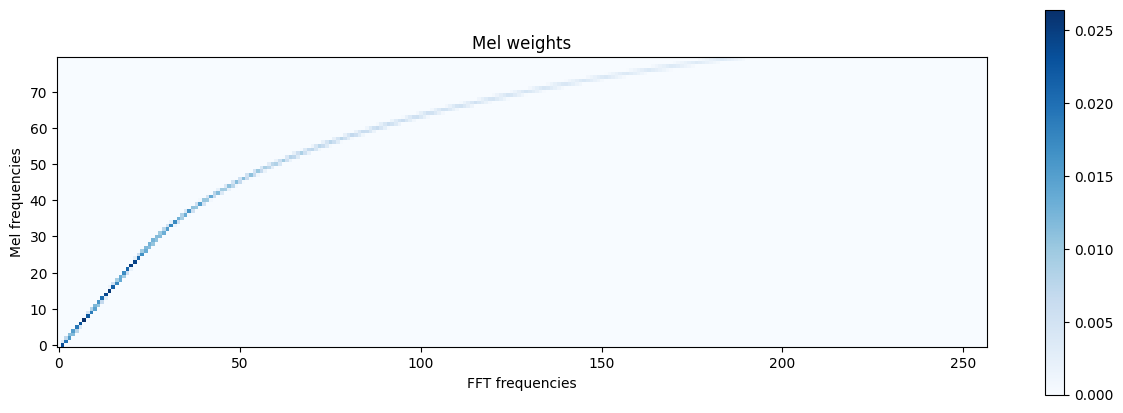

In [20]:
plot_mel_scale()

By multiblying each column of the spectrogram on this matrix, we reduce the number of "frequencies".

As you can see low frequencies here have higher weight, higher frequencies - lower weights.
Very high frequencies are even ignored.

Another good property, that we have achieved - is that the importance of each mel bin for human comprehesion is equal.

We can also condider this transformation reversible.
For restoration of a spectrogram from mel, we can use pseudo-inverse matrix.

To get the mel matrix use [this](https://librosa.org/doc/latest/generated/librosa.filters.mel.html) function with hyperparameters `fmin=1, fmax=8192`. For pseudo-inverse matrix, use [this implementation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html).

**Assignment**: Implement `transforms.Mel` (both `__call__` and `restore` methods)

In [26]:
assert test_mel(testing_class=Mel)

Didn't manage to restore noisy sample number 0.
Input of shape (12, 71) expected result of shape (12, 837).
Got result of shape (12, 837), but the target and result do not match.



AssertionError: 

In [27]:
wav_to_spec = Wav2Spectrogram(window_size=1024, hop_length=256, n_freqs=None)
spec_to_mel = Mel(n_fft=1024, n_mels=80, sample_rate=22050)

spec = wav_to_spec(examples["diesel"])
mel = spec_to_mel(spec)

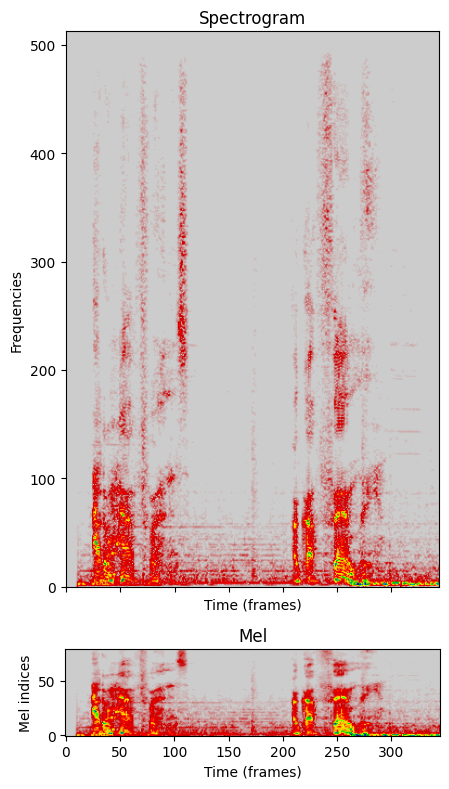

In [28]:
plot_spec_mel(spec, mel)

Let's see how pseudo-inverse matrix restores the spectrogram

/Users/rmnigm/study/speech_course/week_01_DSP/plotting_utils.py:320: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


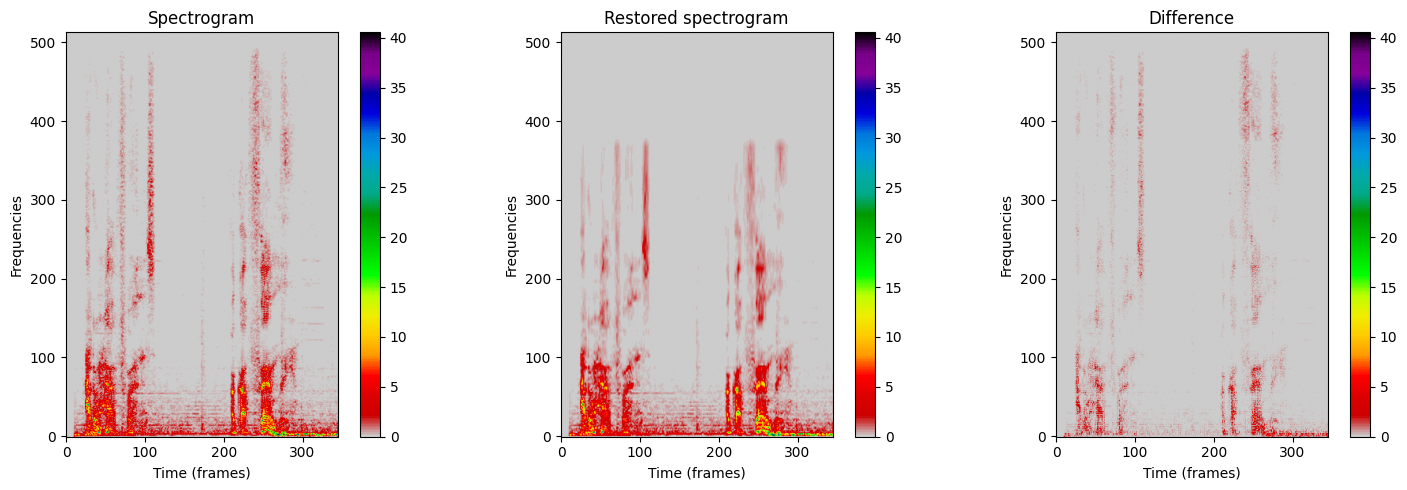

In [29]:
restored_spec = spec_to_mel.restore(mel)
plot_restored_spec(spec, restored_spec)

Visually, we got pretty much the same. Yet the difference is still noticable.

### 6. Let's watch what we've implemented

Now we got the final representation of audio, which can then be fed to a neural network, or some other algorithm.
Why we like log-mel representation?

- It is more compact than spectrogam
- It is more informative than spectrogram
- You can watch on the spectrogram and notice the basic characteristics of the audio: pitch, amount of noise, loudness and so on.

What is constraints about logmel representation?

- There is no phase information which important for some noise reduction algorithms
- It is lossy comppression based on specific assumtion. Thus, it is not suitable for some specific scenarios like analysis of dolphins communications.

For analysis of human perceptive signals it works very well. So Let's draw some specs and try to notice some insights from them

In [ ]:
plot_wav_and_mel(examples)

## Homework section

### 7. Vocoding

In the upcoming chapters, we will need to convert the spectrogram back to the waveform, a process known as vocoding. Logically, this involves performing the inverse discrete Fourier transform of the Discrete Fourier Transform (DFT) results. However, in many cases, we work with log-mel spectrograms of a signal and lack the phase information of the signal.


The simplest way to address vocoding is GriffinLim algorithm.
Shortly, uses intersection of windows to windows to estimate phases.
It is implemented in Wav2Spectrogram.restore method for you.
We do not cover this algorithm in our course, but if you are curious enough to figure out how it works, follow the [link](https://paperswithcode.com/method/griffin-lim-algorithm)

### 8. Spectrogram transformations

Now, as we know how to transform wav to mel spectrogram and backward, we can implement some transformation of audio in mel space.

__Assignment:__

Go to the `transforms` file and mplement the following transformations over mels:

* `TimeReverse` - inverses time.
* `Loudness` - increase/decrease loudness by a given factor. All mel bins are increased proprtionally.
* `PitchDown`, `PitchUp` - make audio sound lower and higher. Move mels up or down, and fills the remaininl mel bins with zeros.
* `SpeedUpDown` - increase/decrease speed of the recording by a given factor. (The same thing you do with this seminar if you watch it recorded=)). The number of mel frames equals to `int(speed_up_factor * number_of_mel_frames)`. And the frames are copied. Each frame with index `idx` is copied to `round(idx * speed_up_factor)`
* `VerticalSwap` - Swap the mels over Y-axis. Let's see what will happen
* `WeakFrequenciesRemoval` - let's assume, that frequencies with low amplitude are not interesting for us. Let's zero frequencies smaller, than a certain quantile and see, what it changes.
* `Cringe1`, `Cringe2` - use your imagination to create a some funny transfomration

In [33]:
def show_transformation(transform_class, wav, kwargs):
    sample_rate = 22050
    wav2mel = Wav2Mel(
        window_size=1024,
        hop_length=256,
        n_freqs=None,
        n_mels=80,
        sample_rate=sample_rate)

    mel_transform = transform_class(**kwargs)

    mel = wav2mel(wav)
    transformed_mel = mel_transform(mel)
    transformed_wav = wav2mel.restore(transformed_mel)

    display(Audio(wav, rate=sample_rate))
    display(Audio(transformed_wav, rate=sample_rate))
    plot_transformed_mels(mel, transformed_mel)
    plt.show()

You can test and listen the classes you implement, by commenting and uncommenting lines in following dict.

In [ ]:
testing_triplets = [
    (TimeReverse, {}, test_time_reverse),
    (Loudness, {"loudness_factor": 0.5}, test_loudness),
    (Loudness, {"loudness_factor": 2.0}, test_loudness),
    (PitchUp, {"num_mels_up": 5}, test_pitch_up),
    (PitchUp, {"num_mels_up": 10}, test_pitch_up),
    (PitchDown, {"num_mels_down": 5}, test_pitch_down),
    (PitchDown, {"num_mels_down": 10}, test_pitch_down),
    (SpeedUpDown, {"speed_up_factor": 0.5}, test_speed_up_down),
    (SpeedUpDown, {"speed_up_factor": 0.8}, test_speed_up_down),
    (SpeedUpDown, {"speed_up_factor": 1.2}, test_speed_up_down),
    (SpeedUpDown, {"speed_up_factor": 2.0}, test_speed_up_down),
    (FrequenciesSwap, {}, test_frequencies_swap),
    (WeakFrequenciesRemoval, {"quantile": 0.9}, test_weak_frequencies_removal),
    (WeakFrequenciesRemoval, {"quantile": 0.99}, test_weak_frequencies_removal),
    (Cringe1, {}, test_dummy),
    (Cringe2, {}, test_dummy),
]

for test_class, kwargs, testing_function in testing_triplets:
    print(f"{test_class.__name__}")
    try:
        assert testing_function(testing_class=test_class)
        show_transformation(test_class, wav, kwargs)
    except NotImplementedError as e:
        print(f"Class {test_class.__name__} is not implemented yet")